# Model with pretrained embeddings
    - Glove embeddings. Vectors of 300 dim.
    - Model: Basic LSTM.


In [1]:
# Header
from __future__ import print_function

import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['image.interpolation'] = 'nearest'



/Users/jorge/anaconda3/envs/tm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version:  1.7.0


## Preprocess data

In [2]:
# Import train and test data

data_path = '../../data/aclImdb/'

X_train = np.load(data_path + 'X_train.npy')
y_train = np.load(data_path + 'y_train.npy')
X_test  = np.load(data_path + 'X_test.npy')
y_test  = np.load(data_path + 'y_test.npy')

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(25000, 200) (25000,)
(25000, 200) (25000,)


## Load embeddings and join with the current dictionary

In [3]:
#Load embeddings
import pandas as pd
import csv
import pickle

# Load worddict
with open(data_path + 'worddict.pickle', 'rb') as pfile:
    worddict = pickle.load(pfile)

embed_dim = 100
df_glove = pd.read_csv("../../data/glove.6B."+str(embed_dim)+"d.txt", index_col=0 ,sep=' ',
                   header = None, quoting=csv.QUOTE_NONE, encoding='utf-8')

#Merge with the dictionary of the current texts: Inner join, only words in the corpus and in glove.
df_glove = df_glove.merge(pd.DataFrame.from_dict(worddict, orient='index'), left_index=True, right_index=True)
print('Merged words: ', df_glove.shape[0])

#Create dictionary: word_number_id --> [glove vector associated]
glove={}
for i,r in df_glove[:].iterrows():
    glove[int(r[0])] = [r[j] for j in range(1,embed_dim+1)]
print('Dictionary length: ', len(glove))

Merged words:  45941
Dictionary length:  45941


## Prepare sequences to model


In [4]:
#Create embeddings 3D tensors
max_len = 100

def embedd(x):
    r = np.zeros((max_len, embed_dim))
    pos = max_len-1
    for i in range(len(x),0,-1):
        found = True
        try:
            v = np.array([glove[x[i-1]]])
        except:
            found = False
        if found and pos>=0:
            r[pos,:] = v 
            pos += -1
    return r
        
X_train = np.array([embedd(s) for s in X_train], dtype=np.float32)
print('Train shape:', X_train.shape)

X_test = np.array([embedd(s) for s in X_test], dtype=np.float32)
print('Test shape:', X_test.shape)

Train shape: (25000, 100, 100)
Test shape: (25000, 100, 100)


## Build model

In [5]:
# Model
num_hidden_rnn = 128 #Num of neurons in the Recurent network 

from tensorflow.contrib.keras import layers, models, optimizers

print('Build model 1 - Basic model...')

# LAYER 1: inputs
seq_prev_input = tf.keras.layers.Input(shape=(max_len, embed_dim), dtype='float32',) 

# LAYER 2: Create embedings
#embeds = tf.keras.layers.Embedding(max_features, dim_embedings, input_length=max_len)(seq_prev_input)

# LAYERS 3: RNN - forwards LSTM with dropout
forward = tf.keras.layers.LSTM(num_hidden_rnn, return_sequences=True,
                 dropout=0.3, recurrent_dropout=0.3, name='Forward1')(seq_prev_input)
rnn_out = tf.keras.layers.LSTM(num_hidden_rnn, return_sequences=False,
                 dropout=0.3, recurrent_dropout=0.3, name='Forward2')(forward)


# LAYER 4: Dense layer to outputs - softmax activation
output = tf.keras.layers.Dense(2, activation='softmax')(rnn_out)

# Model Architecture defined
model_1 = tf.keras.models.Model(inputs=seq_prev_input, outputs=output)
model_1.summary()

# Compile model and select optimizer
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


Instructions for updating:
Use the retry module or similar alternatives.
Build model 1 - Basic model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100)          0         
_________________________________________________________________
Forward1 (LSTM)              (None, 100, 128)          117248    
_________________________________________________________________
Forward2 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 249,090
Trainable params: 249,090
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train
batch_size = 128

print("Train...")
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='../../data/tensorboard/PretrainedEmbeds')
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=20,
                      validation_data=(X_test, y_test), callbacks=[tbCallBack])

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 121s 5ms/step - loss: 0.6538 - acc: 0.6091 - val_loss: 0.5627 - val_acc: 0.7132
Epoch 2/20
25000/25000 [==============================] - 111s 4ms/step - loss: 0.5471 - acc: 0.7274 - val_loss: 0.4674 - val_acc: 0.7815
Epoch 3/20
25000/25000 [==============================] - 122s 5ms/step - loss: 0.4925 - acc: 0.7660 - val_loss: 0.4544 - val_acc: 0.7833
Epoch 4/20
25000/25000 [==============================] - 119s 5ms/step - loss: 0.4733 - acc: 0.7753 - val_loss: 0.4296 - val_acc: 0.7965
Epoch 5/20
25000/25000 [==============================] - 112s 4ms/step - loss: 0.4538 - acc: 0.7884 - val_loss: 0.4069 - val_acc: 0.8128
Epoch 6/20
25000/25000 [==============================] - 111s 4ms/step - loss: 0.4411 - acc: 0.7938 - val_loss: 0.3978 - val_acc: 0.8167
Epoch 7/20
25000/25000 [==============================] - 108s 4ms/step - loss: 0.4224 - acc: 0.8033 - val_loss: 

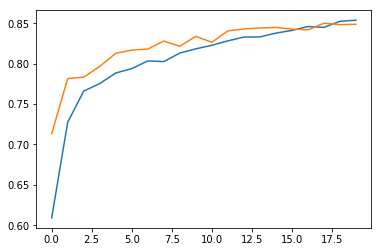

In [7]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

## Validate it

In [8]:
# Score and obtain probabilities
pred_test = model_1.predict(X_test)
print(pred_test.shape)

(25000, 2)


Accuracy:  0.84864
AUC:  0.9314401408000001


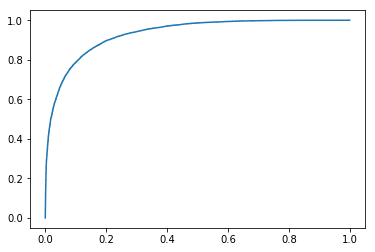

In [9]:
#Import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

#Calculate accuracy with sklearn
print('Accuracy: ',accuracy_score(y_test, [1 if p>0.5 else 0 for p in pred_test[:,1]]))

#Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test[:,1])
print('AUC: ', auc(fpr, tpr) ) 

#Plot ROC curve
plt.plot(fpr, tpr)